# Forecast → Hotspots → Sensor Selection (SciDX) Workflow

This notebook is the **end-to-end workflow** of the project using the same scripts in this repo:

1. **(Optional) Download CAMS inputs** → `download_cams.py`  
2. **Run Aurora** to generate regional forecast CSVs → `run_aurora.py` / `aurora_runner.py`  
3. **Detect hotspot events** from forecast CSVs → `event_detection.py`  
4. **Register hotspot CSV** into SciDX (with `updated_at` in `extras`) → `register_hotspots_csv_scidx.py`  
5. **Register sensor sources** (e.g., Synoptic WebSockets) into SciDX → `register_synoptic_websockets.py`  
6. **Orchestrate:** read hotspots + find nearest sensors → `orchestrate_hotspots_to_sensors.py`

> Goal of the notebook: make it easy to see **what runs when**, **what files are produced**, and **how hotspot → nearby sensor selection works**.


## 0) Setup: environment + config

This demo needs:

- `API_URL`, `TOKEN` in your environment (for SciDX / NDP EP)
- optional `SERVER` (defaults to `local`)
- `config.yaml` at the project root with:
  - `region.name` (e.g., `utah`)
  - `hotspot.url` (where the hotspot CSV is hosted)


In [1]:
import os
from pathlib import Path
import yaml
from dotenv import load_dotenv

load_dotenv(override=True)

API_URL = os.environ.get("API_URL", "").strip()
TOKEN  = os.environ.get("TOKEN", "").strip()
SERVER = (os.environ.get("SERVER") or "local").strip()

print("API_URL:", API_URL)
print("SERVER :", SERVER)
print("TOKEN  :", "set" if TOKEN else "MISSING")

# Load config.yaml
project_root = Path.cwd()
cfg_path = project_root / "config.yaml"

with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

region = str(cfg.get("region", {}).get("name", "")).strip()
hotspot_url = str(cfg.get("hotspot", {}).get("url", "")).strip()

print("region     :", region)
print("hotspot.url:", hotspot_url)


API_URL: 10.244.2.206:8003
SERVER : local
TOKEN  : set
region     : utah
hotspot.url: https://drive.google.com/uc?export=download&id=1YG419lyI9nQgzDLvfayguhe5Sr80_QWk


## 1) Connect to SciDX (catalog/control plane)

We use:
- `ndp_ep.APIClient` for dataset search/metadata
- `scidx_streaming.StreamingClient` for streaming-related helpers and registration


In [2]:
from ndp_ep import APIClient
from scidx_streaming import StreamingClient

client = APIClient(base_url=API_URL, token=TOKEN)
streaming = StreamingClient(client)

print("Streaming user_id:", streaming.user_id)


Streaming user_id: 987104e7-e6d3-47f2-82a0-0d3f620aea70


## 2) (Optional) Download CAMS inputs

If you already have CAMS NetCDF files locally, you can skip this section.

Otherwise run the helper script which pulls CAMS data needed for Aurora.


In [6]:
# run the script as-is (recommended if you're following the repo workflow)
!python src/download_cams.py


print("Downloaded data successfully.")


Static variables already present.
ZIP already exists: data/raw/cams_raw/2025-10-20_0000-1200_12h.nc.zip
Surface-level already exists: data/raw/cams_raw/2025-10-20_0000-1200_12h_surface-level.nc
Atmospheric already exists: data/raw/cams_raw/2025-10-20_0000-1200_12h_atmospheric.nc
Downloaded data successfully.


## 3) Run Aurora → produce regional forecast artifact(s)

This stage turns CAMS inputs into a **regional forecast CSV** for your configured region.


In [3]:
# Run Aurora using the repo script (preferred)
!python src/run_aurora.py

print("A forecast CSV artifact created.")


Running Aurora for 2025-10-20 → /uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/data/processed/predictions/2025-10-20_0000-1200_12h_utah.csv
Loading static variables...
Loading CAMS datasets...
Loading Aurora model...
Surface steps: 13 Atmos steps: 5
Processing hour 1/12
Processing hour 2/12
Processing hour 3/12
Processing hour 4/12
Processing hour 5/12
Processing hour 6/12
Processing hour 7/12
Processing hour 8/12
Processing hour 9/12
Processing hour 10/12
Processing hour 11/12
Processing hour 12/12
Processing hour 1/12
Processing hour 2/12
Processing hour 3/12
Processing hour 4/12
Processing hour 5/12
Processing hour 6/12
Processing hour 7/12
Processing hour 8/12
Processing hour 9/12
Processing hour 10/12
Processing hour 11/12
Processing hour 12/12

Saved hourly predictions with all surface variables to /uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/data/processed/predictions/2025-10-20_0000-1200_12h_utah.csv
A forecast CSV artifact created.


## 4) Event detection on forecast output → generate hotspot CSV

This stage reads the forecast artifact and produces a **hotspot events CSV** with columns like:
- `timestamp`
- `lat_min`, `lat_max`, `lon_min`, `lon_max`
- optionally `pm25_max`, etc.

Run the repo script:


In [4]:
# Run event detection using the repo script
!python src/event_detection.py

print("After running, the hotspot CSV should exist, you need to upload the csv to your desired location and copy the link.")


[event_detection] Processing /uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/data/processed/predictions/2025-10-20_0000-1200_12h_utah.csv
[event_detection] Unique grid cells evaluated: 144
[event_detection] Found 106 persistent hotspots → /uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/data/processed/hotspots/2025-10-20_utah_hotspots.csv
After running, the hotspot CSV should exist, you need to upload the csv to your desired location and copy the link.


## 5) Register hotspot CSV as a SciDX dataset (adds `updated_at` in extras)

This makes the hotspot artifact **discoverable** via SciDX search:
- `extras.dataset_kind = hotspot` (or `hotspots`, depending on your convention)
- `extras.region = utah`
- `extras.updated_at = <UTC ISO timestamp>`  ✅ used for picking the latest run

Run:


In [5]:
# run repo script
!python src/register_hotspots_csv_scidx.py

print("After running, 'hotspots_<region>' should be created/updated in SciDX.")

INFO:scidx_streaming.client.init_client:Extracted user ID: 987104e7-e6d3-47f2-82a0-0d3f620aea70
INFO:scidx_streaming.client.init_client:Kafka details set: HOST=localhost, PORT=9092, PREFIX=data_stream_, MAX_STREAMS=10
INFO:register_hotspots_csv:Streaming client initialized. user_id=987104e7-e6d3-47f2-82a0-0d3f620aea70
INFO:scidx_streaming.client.registration:Dataset 'hotspots_utah' created successfully with 1 resource(s).
INFO:register_hotspots_csv:Registered hotspot CSV dataset 'hotspots_utah' from https://drive.google.com/uc?export=download&id=1YG419lyI9nQgzDLvfayguhe5Sr80_QWk
After running, 'hotspots_<region>' should be created/updated in SciDX.


## 6) Register sensor sources (e.g., Synoptic WebSockets) in SciDX

This step registers sensor *methods* (WebSocket URLs + station metadata).
Then you can discover them using:

`streaming.search_consumption_methods(terms=["sensor", "utah"])`

Run:


In [14]:
# run the repo script
!python src/register_synoptic_websockets.py

# Quick check (should return multiple sensors if already registered):
methods = streaming.search_consumption_methods(terms=["sensor", region])
print("Found methods:", len(methods))
if methods:
    print("Example:", methods[0]["name"])


INFO:scidx_streaming.client.init_client:Extracted user ID: 987104e7-e6d3-47f2-82a0-0d3f620aea70
INFO:scidx_streaming.client.init_client:Kafka details set: HOST=localhost, PORT=9092, PREFIX=data_stream_, MAX_STREAMS=10
INFO:register_synoptic_websockets:Streaming Client initialized. User ID: 987104e7-e6d3-47f2-82a0-0d3f620aea70
INFO:scidx_streaming.client.registration:Dataset 'synoptic_push_qcv_aq' created successfully with 1 resource(s).
INFO:register_synoptic_websockets:Registered dataset=synoptic_push_qcv_aq (station=QCV)
INFO:scidx_streaming.client.registration:Dataset 'synoptic_push_qnr_aq' created successfully with 1 resource(s).
INFO:register_synoptic_websockets:Registered dataset=synoptic_push_qnr_aq (station=QNR)
INFO:scidx_streaming.client.registration:Dataset 'synoptic_push_qhw_aq' created successfully with 1 resource(s).
INFO:register_synoptic_websockets:Registered dataset=synoptic_push_qhw_aq (station=QHW)
INFO:scidx_streaming.client.registration:Dataset 'synoptic_push_quttc

## 7) Pick the *latest* hotspot dataset by `extras.updated_at`

When multiple hotspot datasets exist (e.g., repeated registrations), pick the most recent one.

This uses `client.search_datasets(...)` because `updated_at` is stored in dataset **extras**.


In [4]:
from datetime import datetime

def parse_iso(dt: str):
    if not dt:
        return None
    return datetime.fromisoformat(str(dt).replace("Z", "+00:00"))

hotspot_candidates = client.search_datasets(
    terms=["hotspot", region],
    keys=["extras_dataset_kind", "extras_region"],
    server=SERVER,
)

if not hotspot_candidates:
    hotspot_candidates = client.search_datasets(
        terms=["hotspot", region],
        keys=["extras_dataset_kind", "extras_region"],
        server=SERVER,
    )

print("Hotspot datasets found:", len(hotspot_candidates))

# Keep only those that have extras.updated_at
hotspot_with_time = [
    d for d in hotspot_candidates
    if isinstance(d.get("extras"), dict) and d["extras"].get("updated_at")
]

hotspot_with_time.sort(
    key=lambda d: parse_iso(d["extras"]["updated_at"]),
    reverse=True,
)

latest_hotspot_ds = hotspot_with_time[0]
print("Latest hotspot dataset:", latest_hotspot_ds["name"])
print("updated_at:", latest_hotspot_ds["extras"]["updated_at"])
print("resource url:", latest_hotspot_ds["resources"][0]["url"] if latest_hotspot_ds.get("resources") else None)


Hotspot datasets found: 1
Latest hotspot dataset: hotspots_utah
updated_at: 2026-01-19T21:51:43.050954+00:00
resource url: https://drive.google.com/uc?export=download&id=1YG419lyI9nQgzDLvfayguhe5Sr80_QWk


## 8) Load hotspot CSV correctly (Google Drive note)

If your hotspot CSV is hosted on Google Drive, the `.../view?usp=sharing` URL is **not** a raw CSV.
Pandas will read HTML and throw parsing errors.

This helper converts a Drive *view* link into a *direct download* link.
If you get 404, it's usually because:
- the file is not shared publicly / accessible to your environment, or
- the ID is wrong, or
- your environment can't reach Google Drive.

In that case: host the CSV on a plain HTTP endpoint (or S3/GitHub raw) for easiest ingestion.


In [5]:
import re
import pandas as pd
import requests

def drive_view_to_direct(url: str) -> str:
    m = re.search(r"/file/d/([^/]+)/", url)
    if not m:
        return url
    file_id = m.group(1)
    return f"https://drive.google.com/uc?export=download&id={file_id}"

def read_csv_safely(url: str) -> pd.DataFrame:
    try_url = drive_view_to_direct(url)
    r = requests.get(try_url, timeout=30)
    r.raise_for_status()
    ctype = r.headers.get("Content-Type","")
    if "text/html" in ctype.lower():
        raise RuntimeError(f"Got HTML instead of CSV from {try_url}. Check sharing/hosting.")
    from io import StringIO
    return pd.read_csv(StringIO(r.text))


hotspot_resource_url = None
if latest_hotspot_ds.get("resources"):
    hotspot_resource_url = latest_hotspot_ds["resources"][0].get("url")

chosen_url = hotspot_resource_url or hotspot_url
print("Loading hotspot CSV from:", chosen_url)

hotspots_df = read_csv_safely(chosen_url)
print("Rows:", len(hotspots_df), "Cols:", len(hotspots_df.columns))
hotspots_df.head()


Loading hotspot CSV from: https://drive.google.com/uc?export=download&id=1YG419lyI9nQgzDLvfayguhe5Sr80_QWk
Rows: 65 Cols: 4


,timestamp,lat,lon,pm25
0,2025-10-20T03:00:00+00:00,38.8,248.0,10.482469
1,2025-10-20T03:00:00+00:00,38.8,248.4,10.732413
2,2025-10-20T03:00:00+00:00,39.6,248.0,12.874045
3,2025-10-20T03:00:00+00:00,38.8,248.8,10.234383
4,2025-10-20T03:00:00+00:00,39.2,247.2,11.615437


## 9) Discover sensors (from SciDX) + compute nearest sensor per hotspot

This mirrors your core research goal:
- take a hotspot bounding box
- compute its centroid
- find the nearest registered sensor (by haversine distance)


In [6]:
import math
from datetime import datetime, timezone


def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1 = math.radians(lat1)
    p2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(p1) * math.cos(p2) * math.sin(dl / 2) ** 2
    return 2 * R * math.asin(math.sqrt(a))

sensor_methods = streaming.search_consumption_methods(terms=["sensor", region])
print("Sensor methods found:", len(sensor_methods))


sensors = []
for ds in sensor_methods:
    res = (ds.get("resources") or [{}])[0]
    cfg = (res.get("config") or {})
    lat = cfg.get("latitude")
    lon = cfg.get("longitude")
    if lat is None or lon is None:
        continue
    sensors.append({
        "name": ds.get("name"),
        "station_id": cfg.get("station_id"),
        "lat": float(lat),
        "lon": float(lon),
    })


print("Sensors with coordinates:", len(sensors))
required_cols = {"lat", "lon"}
missing = required_cols - set(hotspots_df.columns)
assert not missing, f"Hotspot CSV missing columns: {missing}"

has_ts = "timestamp" in hotspots_df.columns
has_pm25 = "pm25" in hotspots_df.columns

rows = []

for _, row in hotspots_df.iterrows():

    nearest = min(sensors, key=lambda s: haversine_km(row["lat"], row["lon"], s["lat"], s["lon"]))
    d_km = haversine_km(row["lat"], row["lon"], nearest["lat"], nearest["lon"])
    print(nearest)

    ts_part = f"{row['timestamp']} | " if has_ts else ""
    pm_part = f"PM2.5 = {row['pm25']} → " if has_pm25 else "→ "

    rows.append({
            "timestamp": row["timestamp"] if has_ts else None,
            "pm25": row["pm25"] if has_pm25 else None,
            "hotspot_lat": row["lat"],
            "hotspot_lon": row["lon"],
            "station_id": nearest["station_id"],
            "sensor_name": nearest["name"],
            "sensor_lat": nearest["lat"],
            "sensor_lon": nearest["lon"],
            "distance_km": round(d_km, 3),
        })

    print(f"[HOTSPOT] {ts_part}{pm_part}{nearest['station_id']} ({d_km:.1f} km)")


out_dir = project_root / "data" / "processed" / "map"
out_dir.mkdir(parents=True, exist_ok=True)

date_str = datetime.now(timezone.utc).strftime("%Y-%m-%d")
filename = f"{date_str}_{region}_hotspot_sensor_map.csv"

out_path = out_dir / filename
pd.DataFrame(rows).to_csv(out_path, index=False)

print(f"\nSaved hotspot → sensor mapping to:\n{out_path}")


Sensor methods found: 5
Sensors with coordinates: 5
{'name': 'synoptic_push_qcv_aq', 'station_id': 'QCV', 'lat': 40.59806, 'lon': -111.89417}
[HOTSPOT] 2025-10-20T03:00:00+00:00 | PM2.5 = 10.482469 → QCV (200.1 km)
{'name': 'synoptic_push_qcv_aq', 'station_id': 'QCV', 'lat': 40.59806, 'lon': -111.89417}
[HOTSPOT] 2025-10-20T03:00:00+00:00 | PM2.5 = 10.732413 → QCV (201.5 km)
{'name': 'synoptic_push_qcv_aq', 'station_id': 'QCV', 'lat': 40.59806, 'lon': -111.89417}
[HOTSPOT] 2025-10-20T03:00:00+00:00 | PM2.5 = 12.874045 → QCV (111.3 km)
{'name': 'synoptic_push_qcv_aq', 'station_id': 'QCV', 'lat': 40.59806, 'lon': -111.89417}
[HOTSPOT] 2025-10-20T03:00:00+00:00 | PM2.5 = 10.234383 → QCV (208.6 km)
{'name': 'synoptic_push_qcv_aq', 'station_id': 'QCV', 'lat': 40.59806, 'lon': -111.89417}
[HOTSPOT] 2025-10-20T03:00:00+00:00 | PM2.5 = 11.615437 → QCV (173.6 km)
{'name': 'synoptic_push_qcv_aq', 'station_id': 'QCV', 'lat': 40.59806, 'lon': -111.89417}
[HOTSPOT] 2025-10-20T03:00:00+00:00 | PM2.5

In [7]:
results = streaming.search_consumption_methods(terms=["sensor", region, "QCV"])
print("Found methods with QCV:", len(results))
for m in results:
    print(m)

Found methods with QCV: 1
{'name': 'synoptic_push_qcv_aq', 'description': 'Real-time air quality observations from Synoptic Push for station QCV (Copperview).', 'resources': [{'id': '204c717c-6b12-4196-ad69-78339b4cbba4', 'type': 'websocket', 'name': 'synoptic-push-wss-qcv', 'description': 'Synoptic Push WebSocket stream for QCV.', 'config': {'url': 'wss://push.synopticdata.com/feed/e3636084e69244f5bd4d4d2721cec435/?stid=QCV&vars=PM_25_concentration,ozone_concentration,CO_concentration,NO2_concentration', 'token_env': 'SYNOPTIC_TOKEN', 'station_id': 'QCV', 'station_name': 'Copperview', 'latitude': 40.59806, 'longitude': -111.89417, 'elevation_m': 1343.9}}, {'id': '989af2b6-a6de-4f5b-a642-a7f8bdda426b', 'type': 'kafka', 'name': 'derived stream: data_stream_987104e7-e6d3-47f2-82a0-0d3f620aea70_5', 'description': 'Derived Kafka stream generated from resource IDs: 204c717c-6b12-4196-ad69-78339b4cbba4. Filter semantics: none.', 'config': {'host': 'localhost', 'port': 9092, 'topic': 'data_st

In [8]:
stream = await streaming.create_kafka_stream(
    consumption_method_ids = [results[0]["resources"][0]["id"]],
    filter_semantics=[],
    server = SERVER,
)

topic = stream.data_stream_id
print(f"Stream created: {topic}")

Stream created: data_stream_987104e7-e6d3-47f2-82a0-0d3f620aea70_6


[websocket] CONNECTED url=wss://push.synopticdata.com/feed/e3636084e69244f5bd4d4d2721cec435/?stid=QCV&vars=PM_25_concentration,ozone_concentration,CO_concentration,NO2_concentration
[websocket] batch -> records=1 msg_types={'auth': 1}
[websocket] batch -> records=2 msg_types={'data': 1, 'metadata': 1}
[websocket] batch -> records=2 msg_types={'data': 1, 'metadata': 1}
[websocket] batch -> records=3 msg_types={'data': 2, 'metadata': 1}
[websocket] batch -> records=2 msg_types={'data': 2}


In [ ]:
import asyncio
import json
from pprint import pprint
from datetime import datetime, timedelta, timezone

from scidx_streaming import StreamingClient
from ndp_ep import APIClient
import os
from dotenv import load_dotenv

load_dotenv(override=True)

TOKEN = os.getenv("TOKEN")
API_URL = os.getenv("API_URL")
SERVER = os.getenv("SERVER")

client = APIClient(base_url=API_URL, token=TOKEN)
streaming = StreamingClient(client)

print(f"Streaming Client initialized. User ID: {streaming.user_id}")


topic = "data_stream_987104e7-e6d3-47f2-82a0-0d3f620aea70_5"
print(f"Consuming from topic: {topic}")

consumer = streaming.consume_kafka_messages(topic)


def pretty_print_msg(msg: dict):
    """Nice readable printing for websocket messages"""
    print("\n" + "=" * 80)
    pprint(msg, width=120, sort_dicts=False)
    print("=" * 80 + "\n")


def normalize_payload_cell(cell):
    """
    payload column may contain:
    - dict
    - list of dicts / None
    """
    if isinstance(cell, dict):
        return [cell]
    if isinstance(cell, list):
        return [x for x in cell if isinstance(x, dict)]
    return []

async def main():
    print("Waiting for data...\n")

    end_time = datetime.now(timezone.utc) + timedelta(hours=1)

    seen_messages = set()
    last_df_signature = None

    while datetime.now(timezone.utc) < end_time:
        df = consumer.dataframe

        if df is not None and not df.empty:
            signature = (len(df), df["timestamp"].iloc[-1] if "timestamp" in df.columns else None)
            if signature != last_df_signature:
                last_df_signature = signature
                print("\nUpdated DataFrame (latest rows):")
                print(df.tail(5).to_string(index=False))

            if "payload" in df.columns:
                for cell in df["payload"].dropna():
                    for msg in normalize_payload_cell(cell):
                        msg_key = json.dumps(msg, sort_keys=True, default=str)

                        if msg_key not in seen_messages:
                            seen_messages.add(msg_key)
                            pretty_print_msg(msg)

        await asyncio.sleep(2)

    consumer.stop()
    print("⏹No new data after 1 hour. Stopping consumer.")


await main()


Streaming Client initialized. User ID: 987104e7-e6d3-47f2-82a0-0d3f620aea70
Consuming from topic: data_stream_987104e7-e6d3-47f2-82a0-0d3f620aea70_5
Waiting for data...


Updated DataFrame (latest rows):
             timestamp msg_type                                                                                                                         payload
[2026-01-19T22:00:03Z]   [auth] [{'type': 'auth', 'session': 'a052a649-6313-4712-bd54-0f285ac9ab9e', 'messages': ['Starting new session.'], 'code': 'success'}]

{'type': 'auth',
 'session': 'a052a649-6313-4712-bd54-0f285ac9ab9e',
 'messages': ['Starting new session.'],
 'code': 'success'}


Updated DataFrame (latest rows):
                                   timestamp         msg_type                                                                                                                                                                                                                                                          

[websocket] ws.recv() failed: Connection to remote host was lost.
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/u1494915/streaming-py/scidx_streaming/services/stream_processing/websocket_manager.py", line 59, in _ws_read_loop
    raw = ws.recv()  # blocking
          ^^^^^^^^^
  File "/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/websocket/_core.py", line 395, in recv
    opcode, data = self.recv_data()
                   ^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/websocket/_core.py", line 423, in recv_data
    opcode, frame = self.recv_data_frame(control_frame)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/websocket/_core.py", line 444, in recv_data_frame
    frame = self.recv_frame()
            ^^^^^^^^^^^^^

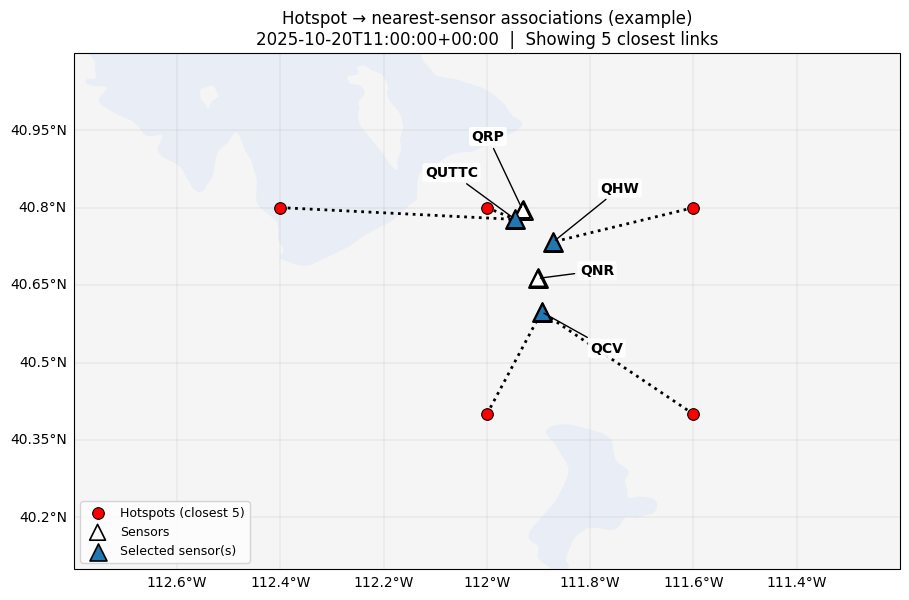

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def to_lon180(series):
    s = pd.to_numeric(series, errors="coerce")
    return ((s + 180.0) % 360.0) - 180.0


sensors = pd.DataFrame([
    ("QCV",   40.59806, -111.89417),
    ("QNR",   40.66284, -111.90180),
    ("QHW",   40.73350, -111.87170),
    ("QUTTC", 40.77710, -111.94500),
    ("QRP",   40.79550, -111.93090),
], columns=["station_id", "lat", "lon"])


map_path = f"{project_root.parent}/data/processed/map/2026-01-15_utah_hotspot_sensor_map.csv"
mapdf = pd.read_csv(map_path)


mapdf["t"] = pd.to_datetime(mapdf["timestamp"], utc=True, errors="coerce")
mapdf["hotspot_lat"] = pd.to_numeric(mapdf["hotspot_lat"], errors="coerce")
mapdf["hotspot_lon"] = to_lon180(mapdf["hotspot_lon"])
mapdf["sensor_lat"]  = pd.to_numeric(mapdf["sensor_lat"], errors="coerce")
mapdf["sensor_lon"]  = to_lon180(mapdf["sensor_lon"])   # safe even if already -111
mapdf["distance_km"] = pd.to_numeric(mapdf["distance_km"], errors="coerce")

N_LINKS = 5   # <= 5 is usually “paper-clean”
map_show = mapdf.sort_values("distance_km", ascending=True).head(N_LINKS).copy()

selected_ids = set(map_show["station_id"].astype(str).unique())
sensors["is_selected"] = sensors["station_id"].isin(selected_ids)

all_lats = np.r_[sensors["lat"].values, map_show["hotspot_lat"].values]
all_lons = np.r_[sensors["lon"].values, map_show["hotspot_lon"].values]
pad_lat, pad_lon = 0.30, 0.40
min_lat, max_lat = all_lats.min() - pad_lat, all_lats.max() + pad_lat
min_lon, max_lon = all_lons.min() - pad_lon, all_lons.max() + pad_lon


fig = plt.figure(figsize=(9.2, 6.2))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND, facecolor="#f5f5f5", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", zorder=0)
ax.add_feature(cfeature.LAKES, facecolor="#e9eef6", edgecolor="none", zorder=0)
ax.add_feature(cfeature.RIVERS, edgecolor="#c7d3e6", linewidth=0.5, zorder=0)
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="#9a9a9a", linewidth=0.8, zorder=1)


gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="#9a9a9a", alpha=0.5)
gl.top_labels = False
gl.right_labels = False


ax.scatter(
    map_show["hotspot_lon"], map_show["hotspot_lat"],
    transform=ccrs.PlateCarree(),
    s=70, marker="o",
    facecolor="red", edgecolor="black", linewidth=0.8,
    zorder=4, label=f"Hotspots (closest {len(map_show)})"
)

ax.scatter(
    sensors["lon"], sensors["lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=180,
    facecolor="white", edgecolor="black", linewidth=1.6,
    zorder=5
)

ax.scatter(
    sensors.loc[~sensors["is_selected"], "lon"],
    sensors.loc[~sensors["is_selected"], "lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=130,
    facecolor="none", edgecolor="black", linewidth=1.2,
    zorder=6, label="Sensors"
)

ax.scatter(
    sensors.loc[sensors["is_selected"], "lon"],
    sensors.loc[sensors["is_selected"], "lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=150,
    facecolor="#1f77b4", edgecolor="black", linewidth=1.2,
    zorder=7, label="Selected sensor(s)"
)

label_pos = {
    "QRP":   (-112.03, 40.93),
    "QUTTC": (-112.12, 40.86),
    "QHW":   (-111.78, 40.83),
    "QNR":   (-111.82, 40.67),
    "QCV":   (-111.80, 40.52),
}
for _, r in sensors.iterrows():
    sid = r["station_id"]
    x0, y0 = r["lon"], r["lat"]
    x1, y1 = label_pos.get(sid, (x0 + 0.03, y0 + 0.03))
    ax.annotate(
        sid,
        xy=(x0, y0), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        xytext=(x1, y1), textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        fontsize=10, weight="bold",
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.92),
        arrowprops=dict(arrowstyle="-", lw=1.0, color="black"),
        zorder=8
    )


for _, r in map_show.iterrows():
    ax.plot(
        [r["hotspot_lon"], r["sensor_lon"]],
        [r["hotspot_lat"], r["sensor_lat"]],
        transform=ccrs.PlateCarree(),
        linestyle=":", linewidth=2.0, color="black",
        zorder=3
    )

ax.legend(loc="lower left", frameon=True)
ax.set_title(
    f"Hotspot → nearest-sensor associations (example)\n"
    f"{ts.isoformat()}  |  Showing {len(map_show)} closest links"
)

plt.tight_layout()
plt.savefig("paper_hotspot_sensor_map_clean.png", dpi=300, bbox_inches="tight")
plt.show()


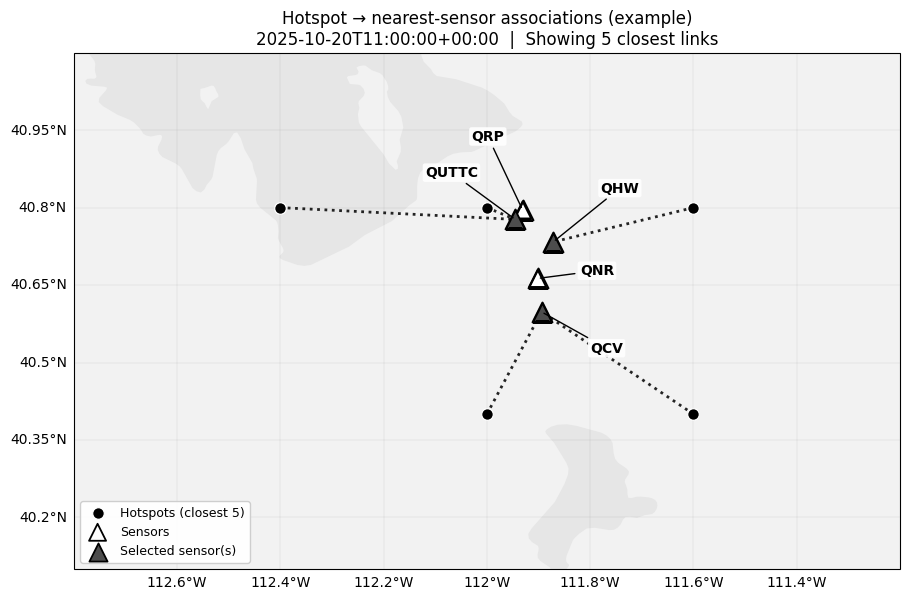

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def to_lon180(series):
    s = pd.to_numeric(series, errors="coerce")
    return ((s + 180.0) % 360.0) - 180.0


sensors = pd.DataFrame([
    ("QCV",   40.59806, -111.89417),
    ("QNR",   40.66284, -111.90180),
    ("QHW",   40.73350, -111.87170),
    ("QUTTC", 40.77710, -111.94500),
    ("QRP",   40.79550, -111.93090),
], columns=["station_id", "lat", "lon"])


map_path = f"{project_root.parent}/data/processed/map/2026-01-15_utah_hotspot_sensor_map.csv"
mapdf = pd.read_csv(map_path)

mapdf["t"] = pd.to_datetime(mapdf["timestamp"], utc=True, errors="coerce")
mapdf["hotspot_lat"] = pd.to_numeric(mapdf["hotspot_lat"], errors="coerce")
mapdf["hotspot_lon"] = to_lon180(mapdf["hotspot_lon"])
mapdf["sensor_lat"]  = pd.to_numeric(mapdf["sensor_lat"], errors="coerce")
mapdf["sensor_lon"]  = to_lon180(mapdf["sensor_lon"])
mapdf["distance_km"] = pd.to_numeric(mapdf["distance_km"], errors="coerce")


N_LINKS = 5
map_show = mapdf.sort_values("distance_km", ascending=True).head(N_LINKS).copy()

selected_ids = set(map_show["station_id"].astype(str).unique())
sensors["is_selected"] = sensors["station_id"].isin(selected_ids)


all_lats = np.r_[sensors["lat"].values, map_show["hotspot_lat"].values]
all_lons = np.r_[sensors["lon"].values, map_show["hotspot_lon"].values]
pad_lat, pad_lon = 0.30, 0.40
min_lat, max_lat = all_lats.min() - pad_lat, all_lats.max() + pad_lat
min_lon, max_lon = all_lons.min() - pad_lon, all_lons.max() + pad_lon


plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

fig = plt.figure(figsize=(9.2, 6.2))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,  facecolor="#f2f2f2", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", zorder=0)
ax.add_feature(cfeature.LAKES, facecolor="#e6e6e6", edgecolor="none", zorder=0)
ax.add_feature(cfeature.RIVERS, edgecolor="#bdbdbd", linewidth=0.5, zorder=1)
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="#8f8f8f", linewidth=0.8, zorder=2)


gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="#8f8f8f", alpha=0.35)
gl.top_labels = False
gl.right_labels = False

for _, r in map_show.iterrows():
    ax.plot(
        [r["hotspot_lon"], r["sensor_lon"]],
        [r["hotspot_lat"], r["sensor_lat"]],
        transform=ccrs.PlateCarree(),
        linestyle=":", linewidth=2.0, color="black",
        alpha=0.85,
        zorder=3
    )

ax.scatter(
    map_show["hotspot_lon"], map_show["hotspot_lat"],
    transform=ccrs.PlateCarree(),
    s=70, marker="o",
    facecolor="black", edgecolor="white", linewidth=0.9,
    zorder=5, label=f"Hotspots (closest {len(map_show)})"
)


ax.scatter(
    sensors["lon"], sensors["lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=200,
    facecolor="white", edgecolor="black", linewidth=1.6,
    zorder=6
)

ax.scatter(
    sensors.loc[~sensors["is_selected"], "lon"],
    sensors.loc[~sensors["is_selected"], "lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=150,
    facecolor="none", edgecolor="black", linewidth=1.3,
    zorder=7, label="Sensors"
)

ax.scatter(
    sensors.loc[sensors["is_selected"], "lon"],
    sensors.loc[sensors["is_selected"], "lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=170,
    facecolor="#4d4d4d", edgecolor="black", linewidth=1.3,
    zorder=8, label="Selected sensor(s)"
)

label_pos = {
    "QRP":   (-112.03, 40.93),
    "QUTTC": (-112.12, 40.86),
    "QHW":   (-111.78, 40.83),
    "QNR":   (-111.82, 40.67),
    "QCV":   (-111.80, 40.52),
}

for _, r in sensors.iterrows():
    sid = r["station_id"]
    x0, y0 = r["lon"], r["lat"]
    x1, y1 = label_pos.get(sid, (x0 + 0.03, y0 + 0.03))
    ax.annotate(
        sid,
        xy=(x0, y0), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        xytext=(x1, y1), textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        fontsize=10, weight="bold",
        bbox=dict(boxstyle="round,pad=0.16", fc="white", ec="none", alpha=0.92),
        arrowprops=dict(arrowstyle="-", lw=1.0, color="black"),
        zorder=9
    )

ax.legend(loc="lower left", frameon=True, facecolor="white", framealpha=0.95)
ax.set_title(
    f"Hotspot → nearest-sensor associations (example)\n"
    f"{ts.isoformat()}  |  Showing {len(map_show)} closest links"
)

plt.tight_layout()

plt.savefig("paper_hotspot_sensor_map_grayscale.png", dpi=600, bbox_inches="tight")
plt.savefig("paper_hotspot_sensor_map_grayscale.pdf", bbox_inches="tight")

plt.show()


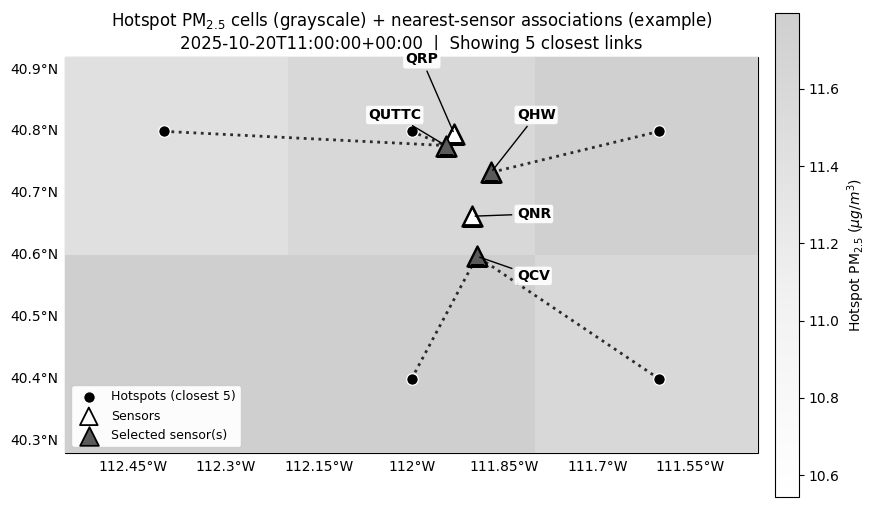

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

def to_lon180(series):
    s = pd.to_numeric(series, errors="coerce")
    return ((s + 180.0) % 360.0) - 180.0

def grid_edges(vals):
    """
    Convert sorted 1D centers -> 1D edges for pcolormesh.
    Works even if spacing is not perfectly uniform.
    """
    vals = np.asarray(vals, dtype=float)
    diffs = np.diff(vals)
    if len(diffs) == 0:
        return np.array([vals[0] - 0.05, vals[0] + 0.05])
    edges = np.empty(len(vals) + 1, dtype=float)
    edges[1:-1] = vals[:-1] + diffs / 2.0
    edges[0] = vals[0] - diffs[0] / 2.0
    edges[-1] = vals[-1] + diffs[-1] / 2.0
    return edges

sensors = pd.DataFrame(
    [
        ("QCV",   40.59806, -111.89417),
        ("QNR",   40.66284, -111.90180),
        ("QHW",   40.73350, -111.87170),
        ("QUTTC", 40.77710, -111.94500),
        ("QRP",   40.79550, -111.93090),
    ],
    columns=["station_id", "lat", "lon"]
)


map_path = f"{project_root.parent}/data/processed/map/2026-01-15_utah_hotspot_sensor_map.csv"
mapdf = pd.read_csv(map_path)

mapdf["t"] = pd.to_datetime(mapdf["timestamp"], utc=True, errors="coerce")
mapdf["hotspot_lat"] = pd.to_numeric(mapdf["hotspot_lat"], errors="coerce")
mapdf["hotspot_lon"] = to_lon180(mapdf["hotspot_lon"])
mapdf["sensor_lat"]  = pd.to_numeric(mapdf["sensor_lat"], errors="coerce")
mapdf["sensor_lon"]  = to_lon180(mapdf["sensor_lon"])
mapdf["distance_km"] = pd.to_numeric(mapdf["distance_km"], errors="coerce")


if "pm25" not in mapdf.columns:
    raise ValueError("Your hotspot_sensor_map CSV must contain a 'pm25' column for PM shading.")
mapdf["pm25"] = pd.to_numeric(mapdf["pm25"], errors="coerce")


ts = pd.to_datetime("2025-10-20T11:00:00+00:00", utc=True)

map_t = mapdf[mapdf["t"] == ts].dropna(
    subset=["hotspot_lat","hotspot_lon","sensor_lat","sensor_lon","distance_km","pm25"]
).copy()

if map_t.empty:
    raise ValueError(
        "No rows in hotspot_sensor_map for this timestamp. "
        "Check available timestamps in mapdf['timestamp'].unique()."
    )

lats = np.sort(map_t["hotspot_lat"].unique())
lons = np.sort(map_t["hotspot_lon"].unique())


pm_grid = (
    map_t.groupby(["hotspot_lat", "hotspot_lon"])["pm25"].max()
        .unstack("hotspot_lon")
        .reindex(index=lats, columns=lons)
        .values
)

lat_edges = grid_edges(lats)
lon_edges = grid_edges(lons)

pm_vals = map_t["pm25"].dropna().values
if len(pm_vals) == 0:
    raise ValueError("No valid pm25 values after cleaning.")


light_greys = mcolors.LinearSegmentedColormap.from_list(
    "light_greys",
    [
        (0.00, "#ffffff"),
        (0.40, "#f2f2f2"),
        (1.00, "#cfcfcf"),
    ]
)
light_greys.set_bad("#ffffff")

vmin = np.percentile(pm_vals, 10)
vmax = np.percentile(pm_vals, 90)
if np.isclose(vmin, vmax):
    vmin = pm_vals.min()
    vmax = pm_vals.max() if pm_vals.max() > pm_vals.min() else pm_vals.min() + 1e-6

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)


pm_grid_masked = np.ma.masked_invalid(pm_grid)


N_LINKS = 5
map_show = map_t.sort_values("distance_km", ascending=True).head(N_LINKS).copy()

selected_ids = set(map_show["station_id"].astype(str).unique())
sensors["is_selected"] = sensors["station_id"].isin(selected_ids)


all_lats = np.r_[sensors["lat"].values, map_show["hotspot_lat"].values]
all_lons = np.r_[sensors["lon"].values, map_show["hotspot_lon"].values]


pad_lat, pad_lon = 0.12, 0.16
min_lat, max_lat = all_lats.min() - pad_lat, all_lats.max() + pad_lat
min_lon, max_lon = all_lons.min() - pad_lon, all_lons.max() + pad_lon


plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

fig = plt.figure(figsize=(9.2, 6.2))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,  facecolor="#f7f7f7", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", zorder=0)
ax.add_feature(cfeature.LAKES, facecolor="#eeeeee", edgecolor="none", zorder=0)
ax.add_feature(cfeature.RIVERS, edgecolor="#c7c7c7", linewidth=0.5, zorder=1)
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="#9a9a9a", linewidth=0.8, zorder=2)


gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="#8f8f8f", alpha=0.30)
gl.top_labels = False
gl.right_labels = False


mesh = ax.pcolormesh(
    lon_edges, lat_edges, pm_grid_masked,
    cmap=light_greys, norm=norm,
    shading="auto",
    transform=ccrs.PlateCarree(),
    zorder=3,
    alpha=1.0
)


cbar = plt.colorbar(mesh, ax=ax, shrink=0.82, pad=0.02)
cbar.set_label("Hotspot PM$_{2.5}$ ($\\mu g/m^3$)")


for _, r in map_show.iterrows():
    ax.plot(
        [r["hotspot_lon"], r["sensor_lon"]],
        [r["hotspot_lat"], r["sensor_lat"]],
        transform=ccrs.PlateCarree(),
        linestyle=":", linewidth=2.0, color="black",
        alpha=0.80,
        zorder=4
    )

ax.scatter(
    map_show["hotspot_lon"], map_show["hotspot_lat"],
    transform=ccrs.PlateCarree(),
    s=70, marker="o",
    facecolor="black", edgecolor="white", linewidth=0.9,
    zorder=6, label=f"Hotspots (closest {len(map_show)})"
)

ax.scatter(
    sensors["lon"], sensors["lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=210,
    facecolor="white", edgecolor="black", linewidth=1.6,
    zorder=7
)


ax.scatter(
    sensors.loc[~sensors["is_selected"], "lon"],
    sensors.loc[~sensors["is_selected"], "lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=160,
    facecolor="none", edgecolor="black", linewidth=1.3,
    zorder=8, label="Sensors"
)

ax.scatter(
    sensors.loc[sensors["is_selected"], "lon"],
    sensors.loc[sensors["is_selected"], "lat"],
    transform=ccrs.PlateCarree(),
    marker="^", s=180,
    facecolor="#5a5a5a", edgecolor="black", linewidth=1.3,
    zorder=9, label="Selected sensor(s)"
)

label_pos = {
    "QRP":   (-112.01, 40.91),
    "QUTTC": (-112.07, 40.82),
    "QHW":   (-111.83, 40.82),
    "QNR":   (-111.83, 40.66),
    "QCV":   (-111.83, 40.56),
}
for _, r in sensors.iterrows():
    sid = r["station_id"]
    x0, y0 = r["lon"], r["lat"]
    x1, y1 = label_pos.get(sid, (x0 + 0.02, y0 + 0.02))
    ax.annotate(
        sid,
        xy=(x0, y0), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        xytext=(x1, y1), textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        fontsize=10, weight="bold",
        bbox=dict(boxstyle="round,pad=0.16", fc="white", ec="none", alpha=0.92),
        arrowprops=dict(arrowstyle="-", lw=1.0, color="black"),
        zorder=10
    )

ax.legend(loc="lower left", frameon=True, facecolor="white", framealpha=0.95)
ax.set_title(
    "Hotspot PM$_{2.5}$ cells (grayscale) + nearest-sensor associations (example)\n"
    f"{ts.isoformat()}  |  Showing {len(map_show)} closest links"
)

plt.tight_layout()

plt.savefig("paper_hotspot_sensor_map_grayscale_pm25.png", dpi=600, bbox_inches="tight")
plt.savefig("paper_hotspot_sensor_map_grayscale_pm25.pdf", bbox_inches="tight")

plt.show()


## 10) Next step: schedule a job on Sage for the selected sensor(s)

At this point you have, for each hotspot:
- hotspot time + bounding box
- nearest sensor station_id (+ coordinates)

Your **next integration point** is to take `station_id` and call scheduler / Sage job launcher, e.g.:

- create a job payload that includes: station_id, time window, variables, output location
- submit the job
